## Import Statements

In [16]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Getting the Data

In [4]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, _subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


## GNN Link Prediction

In [5]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 4433 positive and 4433 negative edges. **


In [6]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)


** Sampled 3990 positive and 3990 negative edges. **


In [7]:
epochs = 50

In [8]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [9]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [12]:
x_inp, x_out = gcn.in_out_tensors()

In [13]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [14]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

history = model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 149ms/step - loss: 4.0657 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 4.0553
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 4.0657
	binary_accuracy: 0.5000


In [19]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 3.9811 - binary_accuracy: 0.5000 - val_loss: 2.1006 - val_binary_accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 2.0943 - binary_accuracy: 0.5000 - val_loss: 1.4349 - val_binary_accuracy: 0.5000 - 269ms/epoch - 269ms/step
Epoch 3/50
1/1 - 0s - loss: 1.4303 - binary_accuracy: 0.5000 - val_loss: 1.0441 - val_binary_accuracy: 0.5016 - 286ms/epoch - 286ms/step
Epoch 4/50
1/1 - 0s - loss: 1.0367 - binary_accuracy: 0.5015 - val_loss: 0.7782 - val_binary_accuracy: 0.5232 - 267ms/epoch - 267ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7753 - binary_accuracy: 0.5269 - val_loss: 0.5970 - val_binary_accuracy: 0.6206 - 266ms/epoch - 266ms/step
Epoch 6/50
1/1 - 0s - loss: 0.5895 - binary_accuracy: 0.6292 - val_loss: 0.5114 - val_binary_accuracy: 0.7657 - 267ms/epoch - 267ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5120 - binary_accuracy: 0.7637 - val_loss: 0.5689 - val_binary_accuracy: 0.8269 - 263ms/epoch - 263ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6114 - binary_acc

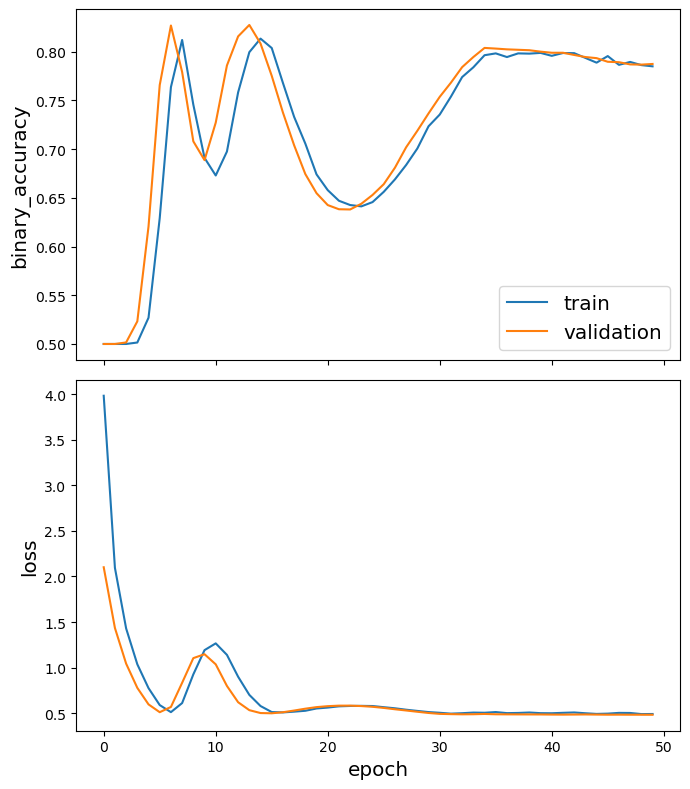

In [20]:
sg.utils.plot_history(history)

In [21]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


1/1 [==============================] - 0s 132ms/step - loss: 0.4832 - binary_accuracy: 0.7874

Train Set Metrics of the trained model:
	loss: 0.4851
	binary_accuracy: 0.7927

Test Set Metrics of the trained model:
	loss: 0.4832
	binary_accuracy: 0.7874
